In [1]:
%matplotlib notebook
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils.mri_viewer import MRIViewer
from utils.data_utils import im_path_to_arr
from utils.config import Config
from utils.dice_score import dice_score
from utils.data_utils import resize_data_to_original_size
from models.fcn_concat import FCN_Concat
from models.fcn_concat_v2 import FCN_Concat_v2

In [2]:
config_path = 'config_files/fcn_concat_finetune_rembrandt_v22.cfg'
config = Config(config_path)
# model = FCN_Concat(config)
model = FCN_Concat_v2(config)

In [ ]:
# for BraTS
# between 1 and 47
patient_id = 11

In [ ]:
# for BraTS
ex_path = '/local-scratch/romains_scratch/brats2017/val/'
patient = os.listdir(ex_path)[patient_id - 1]
patient_path = os.path.join(ex_path, patient)
label_path = os.path.join(patient_path, patient + '_seg.nii')
label = im_path_to_arr(label_path)
flair_path = os.path.join(patient_path, patient + '_flair.nii')
flair = im_path_to_arr(flair_path)
t1post_path = os.path.join(patient_path, patient + '_t1ce.nii')
t1post = im_path_to_arr(t1post_path)

In [3]:
# for Rembrant
# between 1 and 13
patient_id = 5

In [17]:
# for Rembrandt
ex_path = '/local-scratch/romains_scratch/rembrandt/val/'
patient = os.listdir(ex_path)[patient_id - 1]
patient = 'HF1587='
patient_path = os.path.join(ex_path, patient)
label_path = os.path.join(patient_path, 'seg.nii')
label = im_path_to_arr(label_path)
flair_path = os.path.join(patient_path, 'flair.nii')
flair = im_path_to_arr(flair_path)
t1post_path = os.path.join(patient_path, 't1c.nii')
t1post = im_path_to_arr(t1post_path)

### select a patient id between 1 and 193

In [ ]:
patient_id = 10

In [ ]:
# for RTOG
ex_path = '/local-scratch/romain_scratch/rtog/'
patient = os.listdir(ex_path)[patient_id - 1]
patient_path = os.path.join(ex_path, patient)
flair_path = os.path.join(patient_path, 'flair.nii')
flair = im_path_to_arr(flair_path)
t1post_path = os.path.join(patient_path, 't1c.nii')
t1post = im_path_to_arr(t1post_path)
print('shape of this patient is:', t1post.shape)

import gzip

def j(path, fname):
    return os.path.join(path, fname)

patient_path = '/home/romains/rtog_ex2/post'

with gzip.open(j(patient_path, 'flair.nii.gz'), 'rb') as fgz:
            with open(j(patient_path, 'flair.nii'), 'wb') as f:
                f.write(fgz.read())
                
with gzip.open(j(patient_path, 't1c.nii.gz'), 'rb') as fgz:
            with open(j(patient_path, 't1c.nii'), 'wb') as f:
                f.write(fgz.read())

t1post = im_path_to_arr(j(patient_path, 't1c.nii'))
flair = im_path_to_arr(j(patient_path, 'flair.nii'))

In [18]:
patient_path = patient_path.encode('utf-8')
saver = tf.train.Saver()
conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
with tf.Session() as sess:
    saver.restore(sess, config.ckpt_path)
    pred = model.run_pred_single_example_v3(sess, patient_path)
    pred[pred == 3] = 4
patient_path = patient_path.decode('utf-8')

INFO:tensorflow:Restoring parameters from ckpt/fcn_concat_finetune_rembrandt_v22.ckpt


In [19]:
# for Rembrandt and RTOG
# resize to original size
original_size = im_path_to_arr(os.path.join(patient_path, 'flair.nii')).shape
pred = resize_data_to_original_size(pred, original_size)

In [20]:
# for Brats and Rembrandt
def get_dice_scores(p, y):
    dice_whole = dice_score(y, pred)
    fpred_core = (p == 1) + (p == 4)
    fy_core = (y == 1) + (y == 4)
    dice_core = dice_score(fy_core, fpred_core)
    fpred_enhancing = p == 4
    fy_enhancing = y == 4
    dice_enhancing = dice_score(fy_enhancing, fpred_enhancing)
    print('whole: %f ... core: %f ... enhancing: %f ...'%(dice_whole, dice_core, dice_enhancing))
get_dice_scores(pred, label)

whole: 0.872679 ... core: 0.000000 ... enhancing: 0.000000 ...


<IPython.core.display.Javascript object>


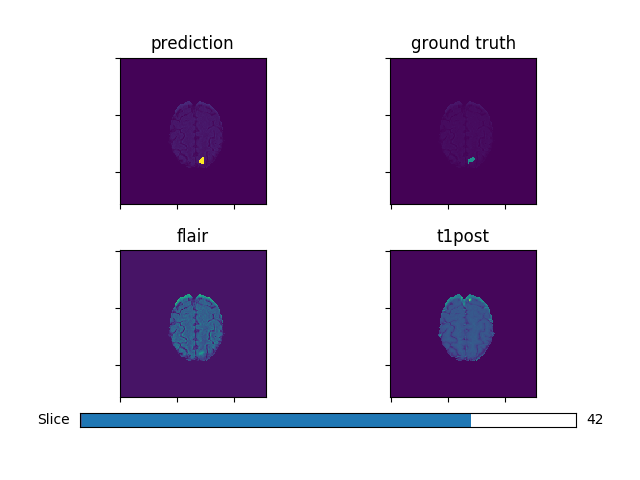

In [21]:
# for Brats and Rembrandt
flair_pred = np.array(flair)
flair_pred[pred == 1] = 1000
flair_pred[pred == 2] = 2000
flair_pred[pred == 4] = 4000
flair_label = np.array(flair)
flair_label[label == 1] = 1000
flair_label[label == 2] = 2000
flair_label[label == 4] = 4000
MRIViewer(flair_pred, flair_label, flair, t1post, cmap=None, title1='prediction', title2='ground truth', title3='flair', title4='t1post')

In [22]:
print(np.count_nonzero(label == 1), np.count_nonzero(pred == 1))
print(np.count_nonzero(label == 2), np.count_nonzero(pred == 2))
print(np.count_nonzero(label == 4), np.count_nonzero(pred == 4))

632 0
21753 18491
170 0


### legend:
- yellow = 2000 = EDEMA
- green = 4000 = ENHANCING
- blue = 1000 = NECROSYS

# Vizualize patients 

In [ ]:
# for Rembrandt
patient_id = 5
ex_path = '/local-scratch/romains_scratch/rembrandt/val/'
patient = os.listdir(ex_path)[patient_id - 1]
patient = 'HF1702='
patient_path = os.path.join(ex_path, patient)
label_path = os.path.join(patient_path, 'seg.nii')
label = im_path_to_arr(label_path)
flair_path = os.path.join(patient_path, 'flair.nii')
flair = im_path_to_arr(flair_path)
t1post_path = os.path.join(patient_path, 't1c.nii')
t1post = im_path_to_arr(t1post_path)
flair_label = np.array(flair)
flair_label[label == 1] = 1000
flair_label[label == 2] = 2000
flair_label[label == 4] = 4000
MRIViewer(flair_label, flair_label, flair, t1post, cmap=None, title1='ground truth', title2='ground truth', title3='flair', title4='t1post')

In [ ]:
print(np.count_nonzero(label == 1))
print(np.count_nonzero(label == 2))
print(np.count_nonzero(label == 4))

In [ ]:
# for Brats
patient_id = 15
ex_path = '/local-scratch/romains_scratch/brats2017/val/'
patient = os.listdir(ex_path)[patient_id - 1]
patient_path = os.path.join(ex_path, patient)
label_path = os.path.join(patient_path, patient + '_seg.nii')
label = im_path_to_arr(label_path)
flair_path = os.path.join(patient_path, patient + '_flair.nii')
flair = im_path_to_arr(flair_path)
t1post_path = os.path.join(patient_path, patient + '_t1ce.nii')
t1post = im_path_to_arr(t1post_path)
flair_label = np.array(flair)
flair_label[label == 1] = 1000
flair_label[label == 2] = 2000
flair_label[label == 4] = 4000
MRIViewer(flair_label, flair_label, flair, t1post, cmap=None, title1='ground truth', title2='ground truth', title3='flair', title4='t1post')

In [ ]:
print(np.count_nonzero(label == 1))
print(np.count_nonzero(label == 2))
print(np.count_nonzero(label == 4))

In [ ]:
# for RTOG
flair_pred = np.array(flair)
flair_pred[pred == 1] = 1000
flair_pred[pred == 2] = 2000
flair_pred[pred == 4] = 4000
MRIViewer(flair_pred, flair_pred, flair, t1post, cmap=None, title1='prediction', title2='prediction', title3='flair', title4='t1post')